In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import sklearn
import george
from george import kernels
from george.modeling import Model
import emcee
import corner
from scipy.optimize import minimize

# changing default font sizes and family
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Cambria' #'serif' Cambria, Times New Roman, Georgia

SN = pd.read_csv('data/LSQ12gdj_photometry.csv')
SN

,event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
0,LSQ12gdj,56237.50000,18.300,NaN,F,NaN,NaN,NaN,"2012ATel.4566....1C,Latest Supernovae"
1,LSQ12gdj,56242.05339,17.487,0.012,F,i,QUEST,ESO Schmidt,2015ApJS..219...13W
2,LSQ12gdj,56242.05846,17.184,0.008,F,r,QUEST,ESO Schmidt,2015ApJS..219...13W
3,LSQ12gdj,56242.06586,17.037,0.008,F,V,QUEST,ESO Schmidt,2015ApJS..219...13W
4,LSQ12gdj,56242.07164,17.006,0.009,F,B,QUEST,ESO Schmidt,2015ApJS..219...13W
...,...,...,...,...,...,...,...,...,...
599,LSQ12gdj,56679.76200,19.351,NaN,T,U,UVOT,Swift,2014Ap&SS.354...89B
600,LSQ12gdj,56679.76270,19.717,NaN,T,B,UVOT,Swift,2014Ap&SS.354...89B
601,LSQ12gdj,56679.76460,20.389,NaN,T,UVW2,UVOT,Swift,2014Ap&SS.354...89B
602,LSQ12gdj,56679.76620,18.782,NaN,T,V,UVOT,Swift,2014Ap&SS.354...89B


In [2]:
time = SN['time']
mag = SN['magnitude']
error = SN['e_magnitude']

UVW2band = np.where(SN['band'] == 'UVW2')[0]
UVM2band = np.where(SN['band'] == 'UVM2')[0]
UVW1band = np.where(SN['band'] == 'UVW1')[0]
Uband = np.where(SN['band'] == 'U')[0]
Bband = np.where(SN['band'] == 'B')[0]
Vband = np.where(SN['band'] == 'V')[0]
Gband = np.where(SN['band'] == 'G')[0]
Rband = np.where(SN['band'] == 'R')[0]
rband = np.where(SN['band'] == 'r')[0]
Iband = np.where(SN['band'] == 'I')[0]
iband = np.where(SN['band'] == 'i')[0]
Zband = np.where(SN['band'] == 'Z')[0]

band_idxs = [UVW2band, UVM2band, UVW1band, Uband, Bband, Vband, Gband, Rband, rband, Iband, iband, Zband]
labels = ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'V', 'G', 'R', 'r', 'I', 'i', 'Z']

print('Number of points: ', len(SN['band']))
print('Sum of points in bands excluding 1 NaN: ', len(iband)+len(rband)+len(Vband)+len(Bband)+
      len(Uband)+len(Zband)+len(Gband)+len(Iband)+len(UVW1band)+len(UVW2band)+len(UVM2band)+len(Rband))

time = time-min(time)

Number of points:  604
Sum of points in bands excluding 1 NaN:  603


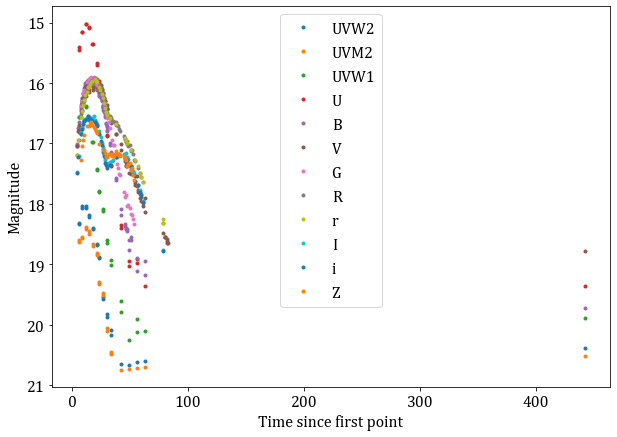

In [25]:
fig = plt.figure(figsize=(10, 7))
for idx, val in enumerate(band_idxs):
    plt.plot(time[val], mag[val], 'o', ms=3, label=labels[idx])
#plt.xlim([0, 100])
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [51]:
use_band, band_str = Rband, 'R' # change this as needed
days_after_peak = 15

peakbright_idx = np.argmin(mag[use_band])
rise_mag = np.asarray(mag[use_band])[:peakbright_idx+days_after_peak]
decline_mag = np.asarray(mag[use_band])[peakbright_idx+days_after_peak:]
rise_time = np.asarray(time[use_band])[:peakbright_idx+days_after_peak]
decline_time = np.asarray(time[use_band])[peakbright_idx+days_after_peak:]

rise_coeff = np.polyfit(rise_time, rise_mag, 2)
decline_coeff = np.polyfit(decline_time, decline_mag, 2)

rise_fit = rise_coeff[0]*rise_time**2 + rise_coeff[1]*rise_time + rise_coeff[2]
decline_fit = decline_coeff[0]*decline_time**2 + decline_coeff[1]*decline_time + decline_coeff[2]

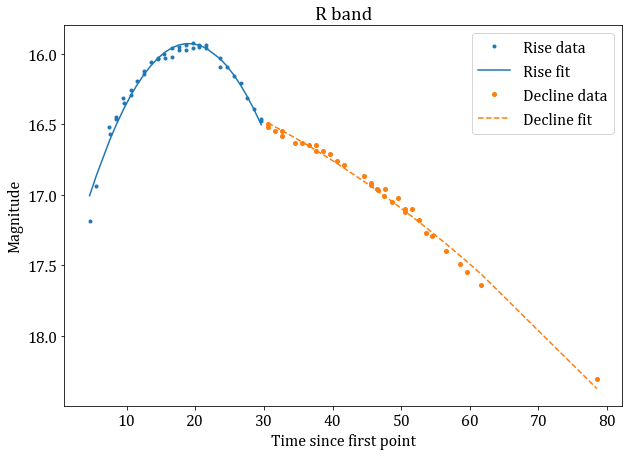

In [52]:
fig = plt.figure(figsize=(10, 7))
plt.plot(rise_time, rise_mag, 'C0o', ms=3, label='Rise data')
plt.plot(rise_time, rise_fit, 'C0-', ms=4, label='Rise fit')
plt.plot(decline_time, decline_mag, 'C1o', ms=4, label='Decline data')
plt.plot(decline_time, decline_fit, 'C1--', ms=4, label='Decline fit')
#plt.plot(np.asarray(time[use_band])[peakbright_idx], np.asarray(mag[use_band])[peakbright_idx], 'rx', ms=10, label='Peak')
plt.title('{} band'.format(band_str))
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [53]:
k = kernels.ExpSquaredKernel(metric=100.0)

In [54]:
class MeanModel(Model):
    parameter_names = ('r0', 'r1', 'r2', 'd0', 'd1', 'd2', 'turn') # peak, rise1, decline1, turnover time
    def set_vector(self, p):
        self.r0, self.r1, self.r2, self.d0, self.d1, self.d2, self.turn = p
    def get_value(self, t):
        # want out a magnitude, given a time
        # before the time where knee mag is reached
        # follow a one quadratic curve
        # after turnover is reached (in time)
        # follow a different quadratic curve
        
        mag_arr = np.array([])
        for i in t:
            if i < self.turn: # before turnover time
                mag = self.r0*i**2 + self.r1*i + self.r2
            else: # after turnover time
                mag = self.d0*i**2 + self.d1*i + self.d2
            mag_arr = np.append(mag_arr, mag)
        return mag_arr
            
r0_init, r1_init, r2_init = rise_coeff
d0_init, d1_init, d2_init = decline_coeff
turn_init = rise_time[-1]

gp = george.GP(mean=MeanModel(r0=r0_init, r1=r1_init, r2=r2_init,
                              d0=d0_init, d1=d1_init, d2=d2_init, turn=turn_init), kernel=k)

In [55]:
gp.get_parameter_dict()

OrderedDict([('mean:r0', 0.0051766890819188605),
             ('mean:r1', -0.1971968882579345),
             ('mean:r2', 17.804608564950602),
             ('mean:d0', 0.00028528262361465415),
             ('mean:d1', 0.008215410506840258),
             ('mean:d2', 15.972699446515565),
             ('mean:turn', 29.599999999998545),
             ('kernel:metric:log_M_0_0', 4.605170185988092)])

73
73


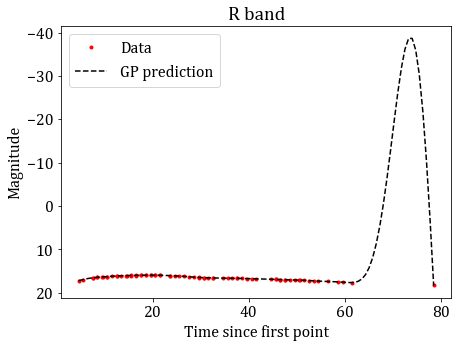

In [56]:
print(len(mag[use_band]))
print(len(error[use_band]))

gp.compute(time[use_band]) # error[use_band]

time_pred = np.linspace(min(time[use_band]), max(time[use_band]), 100)
mag_pred, pred_var = gp.predict(mag[use_band], time_pred, return_var=True)

fig = plt.figure(figsize=(7,5))
#plt.errorbar(time[use_band], mag[use_band], error[use_band], '.', label='Data')
plt.plot(time[use_band], mag[use_band], 'r.', label='Data')
plt.plot(time_pred, mag_pred, 'k--', label='GP prediction')
plt.legend()
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.title('{} band'.format(band_str))
plt.gca().invert_yaxis()

In [44]:
x = time[use_band]
y = mag[use_band]

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: 7307167816.969018
 hess_inv: array([[ 1.49231760e-04, -8.76964819e-03, -1.33175659e-04,
         1.49214601e-04, -8.76829148e-03, -1.59603113e-04,
         1.35368989e-11,  8.71381015e-07],
       [-8.76638396e-03,  5.15513815e-01, -1.33717468e-03,
        -8.76535330e-03,  5.15432516e-01,  2.42984296e-04,
        -7.97111322e-10, -5.10960099e-05],
       [-1.31818709e-04, -1.42695045e-03,  5.00491925e-01,
        -1.32231183e-04, -1.39803375e-03,  4.99986341e-01,
         4.55870832e-11, -1.02680730e-06],
       [ 1.49212162e-04, -8.76847077e-03, -1.33594884e-04,
         1.49195093e-04, -8.76712045e-03, -1.59910511e-04,
         1.35249183e-11,  8.71312221e-07],
       [-8.76485808e-03,  5.15422354e-01, -1.30785602e-03,
        -8.76383372e-03,  5.15341505e-01,  2.64440931e-04,
        -7.96256611e-10, -5.10902548e-05],
       [-1.61241752e-04,  3.33326556e-04,  4.99978819e-01,
        -1.61543647e-04,  3.54336244e-04,  4.99611520e-01,
         3.03366941e-11, -1.14406654e

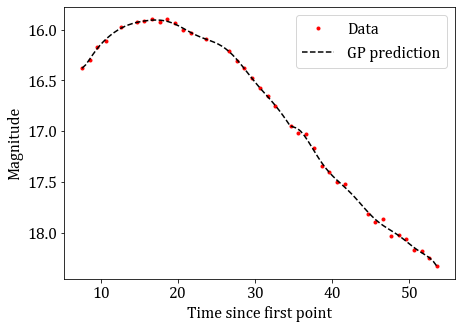

In [45]:
mag_pred, pred_var = gp.predict(mag[use_band], time_pred, return_var=True)

fig = plt.figure(figsize=(7,5))
#plt.errorbar(time[use_band], mag[use_band], error[use_band], '.', label='Data')
plt.plot(time[use_band], mag[use_band], 'r.', label='Data')
plt.plot(time_pred, mag_pred, 'k--', label='GP prediction')
plt.legend()
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()

# STUFF FROM THE HOMEWORK

In [46]:
def lnprob(p):
    if (p[0] < 10) or (p[0] > 20): # prior on peak
        return -np.inf
    if (p[1] < 0) or (p[1] > 0.1): # prior on r0
        return -np.inf
    if (p[2] < -1) or (p[2] > 0): # prior on r1
        return -np.inf
    if (p[3] < 0) or (p[3] > 100): # prior on r2
        return -np.inf
    if (p[4] < 0) or (p[4] > 1.0): # prior on d0
        return -np.inf
    if (p[5] < 0) or (p[5] > 100): # prior on d1
        return -np.inf
    if (p[6] < 0) or (p[6] > 100): # prior on d2
        return -np.inf
    if (p[7] < 0) or (p[7] > 40): # prior on peak_time
        return -np.inf
    if (p[8] < -10.0) or (p[8] > 10.0): # prior on lambda (metric)
        return -np.inf
    
    gp.set_parameter_vector(p)
    return gp.log_likelihood(mag[Rband][::5], quiet=True) + gp.log_prior()

In [ ]:
# from "hyperparameters"
gp.compute(time[Rband][::5])

nwalkers, ndim = 32, len(gp)
nsteps, nburnin = 200, 20
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

p0 = gp.get_parameter_vector() + np.random.randn(nwalkers, ndim)*1e-3

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, nburnin, progress=True)

print("Running production chain")
chain = sampler.run_mcmc(p0, nsteps, progress=True)

In [ ]:
samp = sampler.get_chain()

labels = [r'peak mag', r'$r_0$', r'$r_1$', r'$r_2$', r'$d_0$', r'$d_1$', r'$d_2$', 'time at peak', r'$\lambda$']

fig, axs = plt.subplots(nrows=ndim, ncols=1, figsize=(10, 20), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samp[:,:,i], color='k', alpha=0.1 )
    ax.set_ylabel(labels[i])
    ax.set_xlim(0, nburnin+nsteps)
    ax.axvline(nburnin, color='red')
ax.set_xlabel('Step')

In [ ]:
flat_samples = sampler.get_chain(flat=True)
fig = corner.corner(flat_samples, labels=labels) 

In [ ]:
x = np.linspace(min(time[Rband]), max(time[Rband]), 100)

fig = plt.figure(figsize=(11,7))
#plt.plot(time[Rband], mag[Rband], '.k', ms=2, label='Full data')
for i in range(20):
    w = np.random.randint(sampler.chain.shape[0])
    n = np.random.randint(20, 220) # explicitly excluding burn-in
    gp.set_parameter_vector(sampler.chain[w, n])

    samp = gp.sample_conditional(mag[Rband][::5], x)
    if i == 0:
        plt.plot(x, samp, 'g', alpha=0.2, label='Some possible models')
    else:
        plt.plot(x, samp, 'g', alpha=0.2)
#plt.plot(time[Rband][::5], mag[Rband][::5], '*r', ms=3, label='Condition points')
plt.xlabel('Time since first point')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Posterior models over GP conditioned data')